In [8]:
import numpy as np
import random
from grid_world import GridWorld
from draw import draw
from tqdm import tqdm
from experience_replay_buffer import ExperienceReplayBuffer

rows = 5
cols = 5
env = GridWorld(
    forbidden_score=-10,
    terminal_score=1,
    desc=[".....", ".##..", "..#..", ".#T#.", ".#..."],
)
env.render_grid()


⬜️⬜️⬜️⬜️⬜️
⬜️🚫🚫⬜️⬜️
⬜️⬜️🚫⬜️⬜️
⬜️🚫✅🚫⬜️
⬜️🚫⬜️⬜️⬜️


In [9]:
state_values = np.array([random.random() for i in range(25)])
learning_rate = 0.01
gamma = 0.99

  0%|          | 0/10000 [00:00<?, ?it/s]

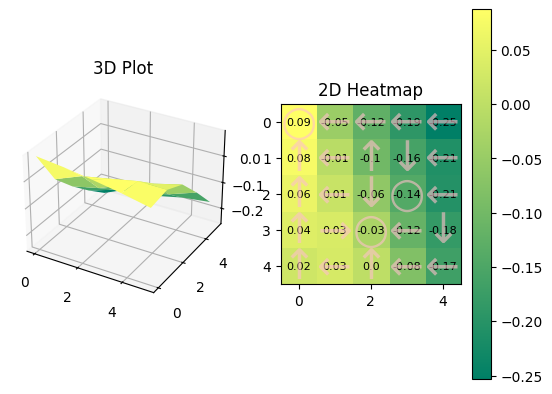

 20%|█▉        | 1975/10000 [00:02<00:08, 983.93it/s]

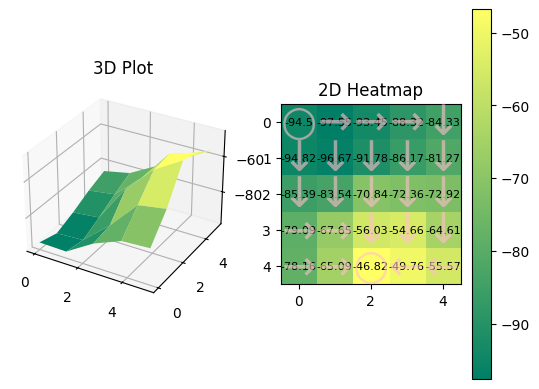

 39%|███▉      | 3915/10000 [00:04<00:06, 965.13it/s]

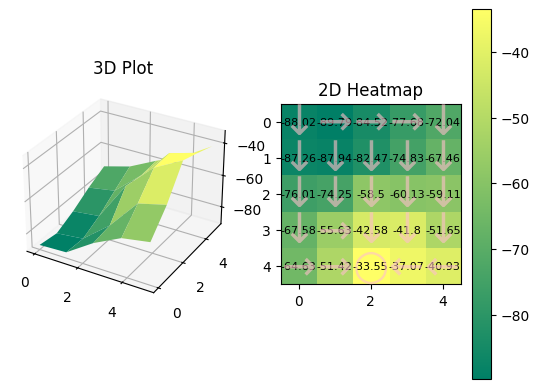

 59%|█████▉    | 5919/10000 [00:06<00:04, 952.68it/s]

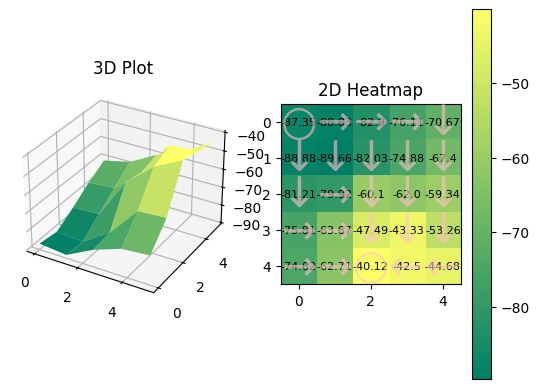

 80%|███████▉  | 7981/10000 [00:09<00:02, 969.35it/s]

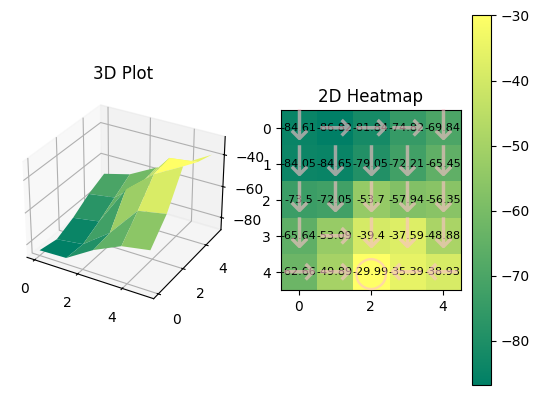

100%|██████████| 10000/10000 [00:11<00:00, 878.35it/s]


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

policy = 0.2 * np.ones((rows * cols, 5))
episodes = [
    env.get_traj(10, action=random.randint(0, 4), policy=policy) for i in range(500)
]
experience_pool = ExperienceReplayBuffer(max_size=10000)
for traj in episodes:
    for exp in traj:
        experience_pool.add_experience(exp)
lr = 0.001
network = model()
optimizer = optim.Adam(network.parameters(), lr=lr)
batch_size = 100

for _ in tqdm(range(10000)):
    batch = experience_pool.sample_batch(batch_size=batch_size)
    state, action, reward, next_state, next_action, terminal = batch

    state = state.reshape(batch_size, -1)
    state = np.hstack((state // 5, state % 5))

    next_state = next_state.reshape(batch_size, -1)
    next_state = np.hstack((next_state // 5, next_state % 5))

    state = torch.tensor(state, dtype=torch.float32).view(batch_size, 2)
    next_state = torch.tensor(next_state, dtype=torch.float32).view(batch_size, 2)

    action = torch.tensor(action, dtype=torch.float32).view(batch_size, 1)
    next_action = torch.tensor(next_action, dtype=torch.float32).view(batch_size, 1)

    reward = torch.tensor(reward, dtype=torch.float32).view(batch_size, 1)
    terminal = torch.tensor(terminal, dtype=torch.float32).view(batch_size, 1)

    with torch.no_grad():
        next_state_value = network(next_state)
        target = reward + (1 - terminal) * gamma * next_state_value

    now_state_value = network(state)
    loss = F.mse_loss(now_state_value, target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if _ % 2000 == 0:
        s = np.array([[i] for i in range(25)])
        s = np.hstack((s // 5, s % 5))
        states = torch.tensor(s, dtype=torch.float32).view(25, 2)

        state_values = network(states).view(-1).detach().numpy()
        action_values = np.random.rand(25, 5)
        for i in range(25):
            for j in range(5):
                reward, nextState = env.get_reward(i, j)
                action_values[i][j] = reward + gamma * state_values[nextState]

        p = np.argmax(action_values, axis=1)
        draw(state_values.reshape(5, 5), p)
